This notebook contains code to measure the burden of deleterious variation from STRs

In [1]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import pyplot as plt
import sys
import pandas as pd

sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from Simulation_functions import *

Populating the interactive namespace from numpy and matplotlib


# New mutations - based on models

In [2]:
# For each class of STRs, we want:
# - motif/opt allele
# - number of STRs
# - mutation rate
# - mean s per mutation
# Then will sum across all categories

# Read in joint results
joint_results = {}
sistr2_scores_file = open('/storage/BonnieH/selection_project/analysis/SISTR2_scores_by_motif_corrected_num_loci.txt', 'r')
sistr2_scores_file.readline()
for line in sistr2_scores_file:
    info = line.strip().split('\t')
    period = int(info[0])
    optimal_ru = int(info[1])
    motif = info[2]
    num_loci = int(info[3])
    est_a = float(info[4])
    est_b = float(info[5])
    joint_results[(period,optimal_ru,motif,num_loci)] = (est_a,est_b)
sistr2_scores_file.close()

# List contents: mu, beta, p, l, optimal ru for the mu value
# Mutation model parameters for different motifs
motif_info = {}
motif_info['eurodem_prior2_dinuc_e_1kg_euro'] = [10**-5, 0.3, 0.6, 0.15, 6]
motif_info['eurodem_prior2_dinuc_d_1kg_euro'] = [10**-4.6, 0.3, 0.6, 0.135, 6]
motif_info['eurodem_prior2_trinuc_e_1kg_euro'] = [10**-6, 0.3, 0.9, 0.3, 5] 
motif_info['eurodem_prior2_tetranuc_b_1kg_euro'] = [10**-5, 0.3, 0.9, 0.25, 3]
motif_info['eurodem_prior2_tetranuc_c_1kg_euro'] = [10**-5.5, 0.3, 0.9, 0.42, 3]
motif_info['eurodem_prior2_tetranuc_d_1kg_euro'] = [10**-6, 0.3, 0.9, 0.45, 3]

# Mutation model settings for different motifs (inferred by SISTR2)
trinuc_motifs = ['ACC','AGG','AGC','CCG','AAG','AAC','ATC','AAT']
dinuc_motifs  = ['AC','AG','AT'] 
tetranuc_motifs = ['AAGG','AAAT','ATCC','AATC','AAAC','AATG','ACAT','AGAT','AAAG'] 
mut_setting = {}
mut_setting['AC'] = 'eurodem_prior2_dinuc_e_1kg_euro'
mut_setting['AG'] = 'eurodem_prior2_dinuc_e_1kg_euro'
mut_setting['AT'] = 'eurodem_prior2_dinuc_d_1kg_euro'
for mot in trinuc_motifs:
    mut_setting[mot] = 'eurodem_prior2_trinuc_e_1kg_euro'
for mot in ['AAAG', 'AAGG', 'AGAT']:
    mut_setting[mot] = 'eurodem_prior2_tetranuc_b_1kg_euro'
for mot in ['ACAT', 'AAAT']:
    mut_setting[mot] = 'eurodem_prior2_tetranuc_c_1kg_euro'
for mot in ['AATC', 'AATG', 'ATCC', 'AAAC']:
    mut_setting[mot] = 'eurodem_prior2_tetranuc_d_1kg_euro'

    
motifs_ = []
opts_ = []
numloci_ = []
means_ = []
muts_ = []
# Get burden for each category
for elem in joint_results:
    # Get params for this class
    setting_info = mut_setting[elem[2]]
    mut_info = motif_info[setting_info]
    num_loci = elem[3] # target size
    
    # Get mutation rate   
    log_mu_prime = np.log10(mut_info[0])+mut_info[3]*(elem[1] - mut_info[4])
    mu_prime = 10**log_mu_prime
    
    if mu_prime < 10**-8: mu_prime = 10**-8 
    if mu_prime > 10**-3: mu_prime = 10**-3

    # Get mean s value of a new mutation
    # Sum over all possible step sizes
    mean_s = 0
    for i in range(-20, 20):
        if elem[1] + i <= 0: continue # can't have negative repeat copy nmber
        prob_step = GetStepSizeProb(0, i, mut_info[1], mut_info[2])
        sval = joint_results[elem][0]*joint_results[elem][1]*abs(i) # a*b*step
        mean_s += prob_step*sval
    
    motifs_.append(elem[2])
    opts_.append(elem[1])
    numloci_.append(num_loci)
    means_.append(mean_s)
    muts_.append(mu_prime)

data = pd.DataFrame({"motif": motifs_,
             "opt": opts_,
             "numloci": numloci_,
             "mean.s": means_,
             "mu": muts_})

In [4]:
# Add scores with reliability of each metric
motif_incl = pd.read_csv("motif_inclusion_kstest.tab", sep="\t")
motif_incl.columns = ["motif","opt", "combine","KS","include","period"]
data = pd.merge(data, motif_incl[["motif","opt","include"]])

In [14]:
# Get burden
data["burden"] = data.apply(lambda x: 2*x["mu"]*x["mean.s"]*x["numloci"], 1)
data.to_csv("figure4-burden-numbers.csv")

data_filt = data[data["include"]]

mean_s = np.sum(data.apply(lambda x: x["numloci"]*x["mean.s"], 1))/np.sum(data["numloci"])
mean_s_filt = np.sum(data_filt.apply(lambda x: x["numloci"]*x["mean.s"], 1))/np.sum(data_filt["numloci"])

num_strs = np.sum(data["numloci"])
num_strs_filt = np.sum(data_filt["numloci"])

mean_mu = np.sum(data.apply(lambda x: x["numloci"]*x["mu"], 1))/np.sum(data["numloci"])
mean_mu_filt = np.sum(data_filt.apply(lambda x: x["numloci"]*x["mu"], 1))/np.sum(data_filt["numloci"])

num_mut = np.sum(data.apply(lambda x: x["numloci"]*x["mu"]*2,1 ))
num_mut_filt = np.sum(data_filt.apply(lambda x: x["numloci"]*x["mu"]*2, 1))

######### Summarize #####################
print("Num loci - all"%num_strs)
print("Num loci - filt"%num_strs_filt)

######### Method 1 - By class ###########
print("Method 1 - total s - all %s"%(np.sum(data["burden"])))
print("Method 1 - total s - filtered %s"%(np.sum(data_filt["burden"])))

print("Method 1 - mean s - all %s"%(mean_s))
print("Method 1 - mean s - filtered %s"%(mean_s_filt))

print("Method 1 - Num mut - all %s"%(num_mut))
print("Method 1 - Num mut - filtered %s"%(num_mut_filt))

######### Method 2 - overall ###########
print("Method 2 - total s - all %s"%(2*mean_mu*num_strs*mean_s))
print("Method 2 - total s - filtered %s"%(2*mean_mu_filt*num_strs_filt*mean_s_filt))

Method 1 - total s - all 0.051146734481617315
Method 1 - total s - filtered 0.01235987090926424
Method 1 - mean s - all 0.0006540766876531336
Method 1 - mean s - filtered 0.000768539949583226
Method 1 - Num mut - all 29.063771726650558
Method 1 - Num mut - filtered 13.77581340105906
Method 2 - total s - all 0.01900993554167439
Method 2 - total s - filtered 0.010587262936717858
Num STRs: 74119
Mean s/mutation: 0.0006540766876531336
Mean mu: 0.00019606154782613472
Overall burden: 0.01900993554167439


# Supp fig. 12 - burden comparison by motif

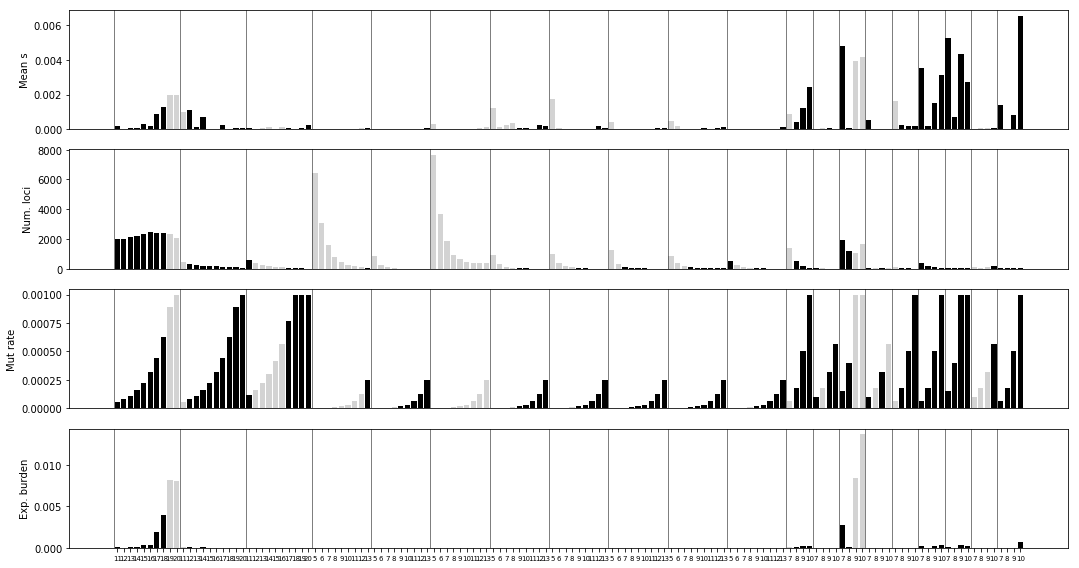

In [44]:
data["period"] = data["motif"].apply(len)
data["color"] = data["include"].apply(lambda x: ["lightgray","black"][x])
data = data.sort_values(["period","motif","opt"])
vertlines = [-0.5]
motifs = [data["motif"].values[0]]
mpos = [0]
for i in range((data.shape[0])-1):
    if data["motif"].values[i] != data["motif"].values[i+1]:
        vertlines.append(i+0.5)
        motifs.append(data["motif"].values[i+1])
        mpos.append(i+1)

fig = plt.figure()
fig.set_size_inches((15, 8))
ax = fig.add_subplot(411)
ax.bar(range(data.shape[0]), (data["mean.s"]), color=data["color"])
ax.set_xticks([])
for vl in vertlines:
    ax.axvline(x=vl, color="black", linewidth=0.5)
#for i in range(len(motifs)):
#    ax.annotate(motifs[i], (mpos[i], 0.006), size=8)
ax.set_ylabel("Mean s")
#ax.set_yscale('log')


ax = fig.add_subplot(412)
ax.bar(range(data.shape[0]), (data["numloci"]), color=data["color"])
ax.set_xticks([])
for vl in vertlines:
    ax.axvline(x=vl, color="black", linewidth=0.5)
#for i in range(len(motifs)):
#    ax.annotate(motifs[i], (mpos[i], 7000), size=8)
ax.set_ylabel("Num. loci")

ax = fig.add_subplot(413)
ax.bar(range(data.shape[0]), (data["mu"]), color=data["color"])
ax.set_xticks([])
for vl in vertlines:
    ax.axvline(x=vl, color="black", linewidth=0.5)
#for i in range(len(motifs)):
#    ax.annotate(motifs[i], (mpos[i], 7000), size=8)
ax.set_ylabel("Mut rate")

ax = fig.add_subplot(414)
ax.bar(range(data.shape[0]), (data["burden"]), color=data["color"])
ax.set_xticks(range(data.shape[0]))
for vl in vertlines:
    ax.axvline(x=vl, color="black", linewidth=0.5)
#for i in range(len(motifs)):
#    ax.annotate(motifs[i], (mpos[i], 0.012), size=8)    
ax.set_xticklabels(data.apply(lambda x: str(x["opt"]), 1), rotation=0, size=7)
ax.set_ylabel("Exp. burden")
#ax.set_yscale('log')
fig.tight_layout()

fig.savefig("SuppFig-burdenByMotif.pdf")
#data

# New mutations - based on observed de novos


**** Notes ***

For de novo analysis: use *delta* of s2.new - s2.old to get the change in burden from parent to child allele. This is closer to what we compare to (expected burden) which assumes all parent alleles were 0

for inherited vs. denovo: compare s2(obs allele) to s2.new. This makes them more comparable, since for inherited variation we don't have any parent


In [7]:
joint_results2 = {} # motif, opt -> s
for elem in joint_results:
    joint_results2[(elem[2], elem[1])] = joint_results[elem][0]*joint_results[elem][1]

In [8]:
# Load gangstr ref
import utils
gref_file = "/gymreklab-tscc/mousavi/analysis/1000genomes/additional_runtime_files/regions/hg38_supp.bed"
gref = pd.read_csv(gref_file, sep="\t", names=["chrom","start","end","period","motif","repseq"])
gref["optimal_ru"] = gref.apply(lambda x: int((x["end"]-x["start"]+1)/x["period"]), 1)
gref["motif"] = gref["motif"].apply(lambda x: utils.GetCanonicalMotif(x))

In [32]:
NUMBS = 100

# Load all de novos + filter
denovos_file = "/storage/hziaeija/variant_trio/trio_variants/monstr_all_filters/CEU_all_filters.csv"
denovo = pd.read_csv(denovos_file)
denovo = denovo[denovo["period"].apply(lambda x: x>=2 and x<=4)]
denovo = denovo[(denovo["encl_mother"]==0) & (denovo["encl_father"]==0) & (denovo["encl_child"]>=5)]
denovo["start"] = denovo["pos"]
denovo = pd.merge(denovo, gref[["chrom","start","period","motif","optimal_ru"]], on=["chrom","start","period"])
denovo["sistr2"] = denovo.apply(lambda x: joint_results2.get((x["motif"], x["optimal_ru"]), float("nan")), 1)
denovo = denovo[~np.isnan(denovo["sistr2"])]

def BootstrapSVals(all_svals_2):
    bs_svals_2 = []
    for i in range(len(all_svals_2)):
        ind = random.randint(0, len(all_svals_2))
        bs_svals_2.append(all_svals_2[ind])
    return bs_svals_2

def GetLowerBS(vals):
    return np.percentile(vals, [2.5])[0] #np.min(vals)

def GetUpperBS(vals):
    return np.percentile(vals, [97.5])[0] #np.max(vals)

# Load scores for inherited burdens for each sample
# Updated: recomputed inherited burden values using the expected fitness (a*b) instead of drawing from the gamma distribution.
iscores = {}
for sample in ["NA12864", "NA10865","NA10845" ]:
    if sample == "NA10865":
        iscores[sample] = [float(item.strip().split()[1]) for item in open("%s_inherited_burden_upd.txt"%sample, "r").readlines()[1:]]    
    else:
        iscores[sample] = [float(item.strip().split()[1]) for item in open("%s_inherited_burden_updated.txt"%sample, "r").readlines()[1:]]    

# Keep track of de novo scores
dscores = {}

for sample in ["NA12864", "NA10865","NA10845" ]:
    denovo_ = denovo[denovo["child"]==sample].copy()
    ddata = denovo_
    ddata["s2.new"] = ddata.apply(lambda x: abs(x["newallele"]-x["optimal_ru"])*x["sistr2"], 1)
    ddata["s2.old"] = ddata.apply(lambda x: abs(x["newallele"]-x["mutsize"]-x["optimal_ru"])*x["sistr2"], 1)
    ddata["s2.delta"] = ddata["s2.new"]-ddata["s2.old"] 

    print ("##### %s #####"%sample)
    print("Num mutations: %s"%ddata.shape[0])
    print("Num mutations neg - sistr2: %s"%ddata[ddata["s2.delta"]>0].shape[0])

    # Get bootstrap CIs for all mutations
    all_svals_2 = list(ddata["s2.delta"])
    
    burden_bs_2 = []
    burden_neg_bs_2 = []
    
    # Bootstrap sample mutations
    for i in range(NUMBS):
        bs_svals_2 = BootstrapSVals(all_svals_2)
        burden_bs_2.append(np.sum(bs_svals_2))
        burden_neg_bs_2.append(np.sum([item for item in bs_svals_2 if item > 0]))
        
    dscores[sample] = list(ddata[ddata["s2.new"]!=0]["s2.new"])
    
    print("Total burden (sistr2): %s (%s-%s)"%(np.sum(ddata["s2.delta"]), GetLowerBS(burden_bs_2), GetUpperBS(burden_bs_2)))
    print("Total burden only neg (sistr2): %s (%s-%s)"%(np.sum(ddata[ddata["s2.delta"]>0]["s2.delta"]), GetLowerBS(burden_neg_bs_2), GetUpperBS(burden_neg_bs_2)))
    

##### NA12864 #####
Num mutations: 100
Num mutations neg - sistr2: 66
Total burden (sistr2): 0.03621148196421 (0.004136948028170997-0.06732495076229174)
Total burden only neg (sistr2): 0.06169499769064 (0.036514269783649494-0.08351969925418797)
##### NA10865 #####
Num mutations: 123
Num mutations neg - sistr2: 90
Total burden (sistr2): 0.025395321247090003 (-0.0076075982144574944-0.050669741434090726)
Total burden only neg (sistr2): 0.05351219099215001 (0.03649929310964525-0.06701567043547624)
##### NA10845 #####
Num mutations: 41
Num mutations neg - sistr2: 29
Total burden (sistr2): 0.031245094125289998 (0.0017503089580970003-0.04807125956071923)
Total burden only neg (sistr2): 0.04016447763868 (0.02408186515568-0.056124476938281986)


# Supp Fig. 13

In [42]:
# Breakdown of inherited burden by motif
iburden = pd.read_csv("fig4_inherited_burden.csv")
iburden["motif"] = iburden["Motif"]
iburden["opt"] = iburden["Optimal_allele"]
iburden = pd.merge(iburden, motif_incl[["motif","opt","include"]])
iburden["period"] = iburden["Motif"].apply(len)
iburden["color"] = iburden["include"].apply(lambda x: ["lightgray","black"][x])

iburden = iburden.sort_values(["period","Motif","Optimal_allele"])
vertlines = [-0.5]
motifs = [iburden["Motif"].values[0]]
mpos = [0]
for i in range((iburden.shape[0])-1):
    if iburden["Motif"].values[i] != iburden["Motif"].values[i+1]:
        vertlines.append(i+0.5)
        motifs.append(iburden["Motif"].values[i+1])
        mpos.append(i+1)

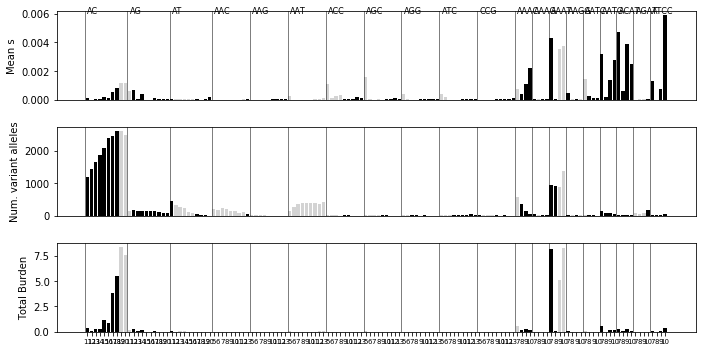

In [43]:
fig = plt.figure()
fig.set_size_inches((10, 5))
ax = fig.add_subplot(311)
ax.bar(range(iburden.shape[0]), (iburden["Expected_s_value"]), color=iburden["color"])
ax.set_xticks([])
for vl in vertlines:
    ax.axvline(x=vl, color="black", linewidth=0.5)
for i in range(len(motifs)):
    ax.annotate(motifs[i], (mpos[i], 0.006), size=8)
ax.set_ylabel("Mean s")
#ax.set_yscale('log')


ax = fig.add_subplot(312)
ax.bar(range(iburden.shape[0]), (iburden["Num_variant_alleles"]), color=iburden["color"])
ax.set_xticks([])
for vl in vertlines:
    ax.axvline(x=vl, color="black", linewidth=0.5)
#for i in range(len(motifs)):
#    ax.annotate(motifs[i], (mpos[i], 2200), size=8)
ax.set_ylabel("Num. variant alleles")

ax = fig.add_subplot(313)
ax.bar(range(iburden.shape[0]), (iburden["Burden"]), color=iburden["color"])
ax.set_xticks(range(iburden.shape[0]))
for vl in vertlines:
    ax.axvline(x=vl, color="black", linewidth=0.5)
#for i in range(len(motifs)):
#    ax.annotate(motifs[i], (mpos[i], 0.012), size=8)    
ax.set_xticklabels(iburden.apply(lambda x: str(x["Optimal_allele"]), 1), rotation=0, size=7)
ax.set_ylabel("Total Burden")
#ax.set_yscale('log')
fig.tight_layout()

fig.savefig("SuppFig-burdenByMotif-Inherited-NA12864.pdf")

NA12864 numloci_inherited=35620 numloci_denovo=92
NA10865 numloci_inherited=35715 numloci_denovo=115
NA10845 numloci_inherited=36102 numloci_denovo=36


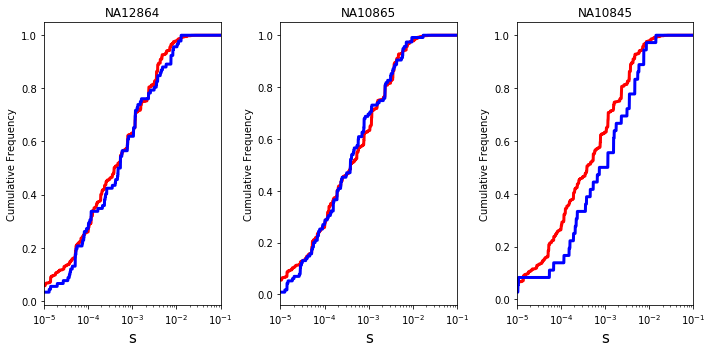

In [33]:
# Plot CDFs

def getCDF(s_list):
    bins_list = [0]
    exponents = [10**-5, 10**-4, 10**-3, 10**-2]
    for j in exponents:
        for i in np.arange(1,10,0.01):
            bins_list.append(i*j)

    bins_list.append(0.1)
    bins_list.append(1)

    values, base = np.histogram(s_list, bins=bins_list)# [0,10**-5,10**-4,10**-3,10**-2,10**-1,1]#[0,10**-5,10**-4,10**-3,10**-2,10**-1,1]

    cumulative = list(np.cumsum(values))
    maximum = max(cumulative)
    cumulative_scaled = []
    for elem in cumulative:
        elem = elem/maximum
        cumulative_scaled.append(elem)

    #cum_dic[motif] = cumulative_scaled
    base_plot = base
    
    return cumulative_scaled, base_plot

color_dic_motif = {}
color_dic_motif['Inherited'] = 'red'
color_dic_motif['Denovo'] = 'blue'

fig = plt.figure()
fig.set_size_inches((10, 5))
fignum = 1

for sample in ["NA12864", "NA10865","NA10845" ]:
    ax = fig.add_subplot(1, 3, fignum)
    
    cum_dic = {}
    
    cumulative_scaled, base_plot = getCDF(iscores[sample])
    cum_dic["Inherited"] = cumulative_scaled

    cumulative_scaled, base_plot = getCDF(dscores[sample])
    cum_dic["Denovo"] = cumulative_scaled

    for elem in cum_dic:
        plt.plot(base_plot[:-1], cum_dic[elem], label = elem , color=color_dic_motif[elem], linewidth = 3, ls='solid')

    print("%s numloci_inherited=%s numloci_denovo=%s"%(sample, len(iscores[sample]), len(dscores[sample])))
    plt.xlim(10**-5, 0.1)
    plt.xscale('log')
    plt.title(sample)
    plt.xlabel('s', fontsize=15)
    #plt.legend(bbox_to_anchor=(1, 1)) 
    plt.ylabel('Cumulative Frequency')
    fignum += 1

fig.tight_layout()
fig.savefig("InheritedVsDenovo.pdf")